In [ ]:
from google.colab import files
files.upload()

{}

In [ ]:
import sys, re
!pip install transformers
from transformers import BertTokenizer, BertModel, AdamW, get_cosine_schedule_with_warmup
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
!unzip Data.zip

Archive:  Data.zip
   creating: Data/
  inflating: __MACOSX/._Data         
   creating: Data/Test_Data/
  inflating: __MACOSX/Data/._Test_Data  
  inflating: Data/Validation_and_Test_Data.ipynb  
  inflating: __MACOSX/Data/._Validation_and_Test_Data.ipynb  
   creating: Data/Train_Data/
  inflating: __MACOSX/Data/._Train_Data  
   creating: Data/Validation_Data/
  inflating: __MACOSX/Data/._Validation_Data  
  inflating: Data/Train_Data_Augmentation_and_PreProcessing.ipynb  
  inflating: __MACOSX/Data/._Train_Data_Augmentation_and_PreProcessing.ipynb  
   creating: Data/.ipynb_checkpoints/
  inflating: __MACOSX/Data/._.ipynb_checkpoints  
   creating: Data/Test_Data/un_processed/
  inflating: __MACOSX/Data/Test_Data/._un_processed  
   creating: Data/Test_Data/pre_processed/
  inflating: __MACOSX/Data/Test_Data/._pre_processed  
   creating: Data/Train_Data/UnProcessed/
  inflating: __MACOSX/Data/Train_Data/._UnProcessed  
   creating: Data/Train_Data/pre_processed/
  inflating: __MAC

In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: Tesla V100-SXM2-16GB


*Loading the Datasets*

In [ ]:
import pandas as pd

train_data_17k_unprocessed_path= "/content/Data/Train_Data/UnProcessed/translated_data_train_16k_format_fix.csv"
train_data_17k_pre_lem_sw_path = "/content/Data/Train_Data/pre_processed/train_data_lemmatized_sw_removed.csv"



train_data_17k_unprocessed = pd.read_csv(train_data_17k_unprocessed_path)
train_data_unprocessed_unaugmented = train_data_17k_unprocessed.iloc[:4355]
train_data_17k_pre_lem_sw= pd.read_csv(train_data_17k_pre_lem_sw_path)

test_data_unprocessed_path= "Data/Test_Data/un_processed/test_data_filtered.csv"
test_data_pre_lem_sw_path = 'Data/Test_Data/pre_processed/test_data_lemmatized_sw_removed.csv'

test_data_unprocessed= pd.read_csv(test_data_unprocessed_path)
test_data_pre_lem_sw= pd.read_csv(test_data_pre_lem_sw_path)



In [ ]:
def reset_ids(df):
    df['id'] = range(1, len(df) + 1)
    return df

In [ ]:

train_data_17k_unprocessed_path= "/content/train_data_unprocessed.csv"
train_data_17k_pre_lem_path = '/content/Data/Train_Data/pre_processed/train_data_lemmatized.csv'
train_data_17k_pre_lem_sw_path = "/content/Data/Train_Data/pre_processed/train_data_lemmatized_sw_removed.csv"
train_data_17k_pre_sw_path= "/content/Data/Train_Data/pre_processed/train_data_sw_removed.csv"



train_data_17k_unprocessed = pd.read_csv(train_data_17k_unprocessed_path, index_col=0)
train_data_17k_unprocessed.reset_index(inplace=True)


train_data_17k_unprocessed= reset_ids(train_data_17k_unprocessed)


train_data_unprocessed_unaugmented = train_data_17k_unprocessed.iloc[:4355]
train_data_17k_pre_lem_sw= pd.read_csv(train_data_17k_pre_lem_sw_path)
train_data_17k_pre_sw= pd.read_csv(train_data_17k_pre_sw_path)
train_data_17k_pre_lem= pd.read_csv(train_data_17k_pre_lem_path)



In [ ]:
test_data_unprocessed_path= "Data/Test_Data/un_processed/test_data_filtered.csv"
test_data_pre_lem_sw_path = 'Data/Test_Data/pre_processed/test_data_lemmatized_sw_removed.csv'

test_data_unprocessed= pd.read_csv(test_data_unprocessed_path, index_col=0)
test_data_unprocessed= test_data_unprocessed.reset_index(drop=True)
test_data_pre_lem_sw= pd.read_csv(test_data_pre_lem_sw_path)


In [ ]:
valid_data_unprocessed_path= "Data/Validation_Data/UnProcessed/validation_data_filtered.csv"
valid_data_pre_lem_path= "Data/Validation_Data/pre_processed/validation_data_lemmatized.csv"
valid_data_pre_lem_sw_path= "Data/Validation_Data/pre_processed/validation_data_lemmatized_sw_removed.csv"
valid_data_pre_sw_path="Data/Validation_Data/pre_processed/validation_data_sw_removed.csv"

valid_data_unprocessed=pd.read_csv(valid_data_unprocessed_path, index_col=0)
valid_data_pre_lem=pd.read_csv(valid_data_pre_lem_path, index_col=0)
valid_data_pre_lem_sw=pd.read_csv(valid_data_pre_lem_sw_path, index_col=0)
valid_data_pre_sw= pd.read_csv(valid_data_pre_sw_path, index_col=0)


In [ ]:
#Function to split the datasets by language

from torch.utils.data import TensorDataset

def split_lang(df, tokenizer):


    tokenized_la = tokenizer(df['la'].tolist(), padding=True, truncation=True, max_length=256, return_tensors="pt")
    features_la = tokenized_la['input_ids']
    attention_mask_la = tokenized_la['attention_mask']

    # Tokenize 'en' column and include attention mask
    tokenized_en = tokenizer(df['en'].tolist(), padding=True, truncation=True, max_length=256, return_tensors="pt")
    features_en = tokenized_en['input_ids']
    attention_mask_en = tokenized_en['attention_mask']



    assert len(features_la) == len(df) and len(features_en) == len(df), "Tokenization output length does not match DataFrame length"

    # Convert file paths to numerical labels
    file_to_idx = {file: idx for idx, file in enumerate(df['file'].unique())}
    labels = torch.tensor([file_to_idx[file] for file in df['file'].values])

    print(labels[1])


    # Create TensorDatasets
    dataset_la = TensorDataset(features_la, attention_mask_la, labels)
    dataset_en = TensorDataset(features_en, attention_mask_en, labels)



    assert len(dataset_la) == len(df) and len(dataset_en) == len(df), "TensorDataset size does not match DataFrame size"

    return dataset_la, dataset_en



In [ ]:
#functions to allign the feature embeddings

def reset_id_column(df):

    # Reset the index to start from 0 and then adjust to start from 1
    df = df.reset_index(drop=True)
    df.index += 1

    df['id'] = df.index

    return df

def sort_dataframe_by_file(df):
    """
    Sorts the DataFrame based on the 'file' column in alphabetical order.

    Args:
    df (pd.DataFrame): The DataFrame to be sorted.

    Returns:
    pd.DataFrame: The sorted DataFrame.
    """
    if 'file' in df.columns:
        # Sort the DataFrame based on the 'file' column
        sorted_df = df.sort_values(by='file', ascending=True)
        return sorted_df
    else:
        print("The DataFrame does not have a 'file' column.")
        return df

In [ ]:
train_data_unprocessed_unaugmented_sorted= sort_dataframe_by_file(train_data_unprocessed_unaugmented)

test_data_unprocessed_sorted= sort_dataframe_by_file(test_data_unprocessed)

In [ ]:
multilingual_BERT_tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [ ]:
la_train_unp_unaug, en_train_unp_unaug = split_lang(train_data_unprocessed_unaugmented_sorted, multilingual_BERT_tokenizer)


tensor(0)


In [ ]:
la_test_unp, en_test_unp = split_lang(test_data_unprocessed_sorted, multilingual_BERT_tokenizer)


tensor(0)


*Defining the model and the classifier*

In [ ]:


number_of_authors= 5
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(768, 768)  # to make it comparable to what was done in contra x paper.
        self.fc2 = nn.Linear(768, number_of_authors)
        self.dropout = nn.Dropout(0.35)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


class MultilingualBertForAuthorshipAttribution(nn.Module):
    def __init__(self, bert_model, classifier):
        super(MultilingualBertForAuthorshipAttribution, self).__init__()
        self.bert_model = bert_model
        self.classifier = classifier

    def forward(self, input_ids, attention_mask):
        outputs = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]  # The pooled output can be treated as embeddings
        classifier_output = self.classifier(pooled_output)
        return pooled_output, classifier_output


*Loss Function*

In [ ]:
def noncontrastive_loss_function(outputs, labels, embeddings, temperature=0.1, lambda_coef=1.0):

    # Cross-entropy loss
    LCE = F.cross_entropy(outputs, labels)


    combined_loss = LCE

    return combined_loss

*Training Function*

In [ ]:
from torch.utils.data import DataLoader

def train_model_non_cont(model, train_dataset, val_dataset, lambda_coef=1.0, temperature=0.1, learning_rate=2e-5, num_epochs=8, batch_size=24, weight_decay=0.0001, l1_lambda=0.001):
    """
    Train the model with the specified parameters.
    """
    model = model.to(device)

    # Create DataLoaders for the training and validation data
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Initialize the optimizer with L2 regularization (weight decay)
    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    total_steps = len(train_loader) * num_epochs
    # Initialize the learning rate scheduler
    scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    training_losses = []
    validation_losses = []

    # Early stopping parameters
    no_improvement = 0
    min_val_loss = float('inf')

    # Set the model to training mode
    model.train()

    for epoch in range(num_epochs):
        total_train_loss = 0

        # Training phase
        for batch in train_loader:
            inputs, attention_mask, labels = batch
            inputs, attention_mask, labels = inputs.to(device), attention_mask.to(device), labels.to(device)

            # Forward pass: Compute embeddings and output logits from the model
            embeddings, outputs = model(inputs, attention_mask)

            # Compute the non-contrastive loss
            loss = noncontrastive_loss_function(outputs, labels, embeddings, temperature, lambda_coef)

            # L1 regularization term
            l1_reg = sum(torch.sum(torch.abs(param)) for param in model.parameters())
            loss += l1_lambda * l1_reg

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        training_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for batch in val_loader:
                inputs, attention_mask, labels = batch
                inputs, attention_mask, labels = inputs.to(device), attention_mask.to(device), labels.to(device)

                embeddings, outputs = model(inputs, attention_mask)
                loss = noncontrastive_loss_function(outputs, labels, embeddings, temperature, lambda_coef)

                # L1 regularization term also during validation
                l1_reg = sum(torch.sum(torch.abs(param)) for param in model.parameters())
                loss += l1_lambda * l1_reg

                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        validation_losses.append(avg_val_loss)

        # Check for early stopping
        if avg_val_loss < min_val_loss:
            min_val_loss = avg_val_loss
            no_improvement = 0
        else:
            no_improvement += 1

        if no_improvement >= 2:
            print(f'Early stopping triggered at epoch {epoch+1}')
            break

        model.train()  # Switch back to training mode

        print(f'Epoch {epoch+1}/{num_epochs} completed. Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    print('Training completed')

    plt.figure(figsize=(10, 6))
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs mBERT Non-Contrastive Learning')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return model


*Evaluation Function*

In [ ]:
from sklearn.metrics import accuracy_score

def evaluate_model(model, test_data, phrase, device=device, batch_size=24):
    """
    Evaluate the model on the test dataset.

    Args:
    model (torch.nn.Module): The trained model to be evaluated.
    test_data (TensorDataset): The test dataset.
    phrase (str): Description phrase for logging.
    device (str): The device to run the model on, 'cpu' or 'cuda'.
    batch_size (int): Batch size for evaluation.

    Returns:
    float: The accuracy of the model on the test dataset.
    """
    model.eval()  # Set the model to evaluation mode

    # Create a DataLoader for the test data
    test_loader = DataLoader(test_data, batch_size=batch_size)

    true_labels = []
    predictions = []
    examples_printed = 0

    with torch.no_grad():  # No need to track gradients during evaluation
        for batch in test_loader:
            inputs, attention_mask, labels = batch
            inputs, attention_mask, labels = inputs.to(device), attention_mask.to(device), labels.to(device)

            embeddings, outputs = model(inputs, attention_mask=attention_mask)
            _, predicted = torch.max(outputs, 1)

            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

            # Print some examples
            if examples_printed < 5:
                for i in range(batch_size):
                    examples_printed += 1
                    if examples_printed >= 5:
                        break

    accuracy = accuracy_score(true_labels, predictions)
    return accuracy

*Model Training:*

unprocessed unaugmented data:

In [ ]:
multilingual_BERT_model__lat_unp_unaug = BertModel.from_pretrained("bert-base-multilingual-uncased")
multilingual_BERT_model__en_unp_unaug=  BertModel.from_pretrained("bert-base-multilingual-uncased")

classifier_lat_unp_unaug = Classifier()
classifier_en_unp_unaug = Classifier()


multilingual_bert_authorship_model_lat_unp_unaug= MultilingualBertForAuthorshipAttribution(multilingual_BERT_model__lat_unp_unaug, classifier_lat_unp_unaug)
multilingual_bert_authorship_model_en_unp_unaug = MultilingualBertForAuthorshipAttribution(multilingual_BERT_model__en_unp_unaug, classifier_en_unp_unaug)

# Seed for reproducibility
torch.manual_seed(42)

# Shuffle indices for 'la_train_unp_unaug'
la_indices = torch.randperm(len(la_train_unp_unaug))
la_train_unp_unaug = TensorDataset(*[t[la_indices] for t in la_train_unp_unaug.tensors])

# Shuffle indices for 'en_train_unp_unaug'
en_indices = torch.randperm(len(en_train_unp_unaug))
en_train_unp_unaug = TensorDataset(*[t[en_indices] for t in en_train_unp_unaug.tensors])


valid_data_unprocessed_la, valid_data_unprocessed_en = split_lang(valid_data_unprocessed, multilingual_BERT_tokenizer)


num_samples = 2

print("Samples from la_train_unp_unaug:")
for i in range(min(num_samples, len(la_train_unp_unaug))):
    sample = la_train_unp_unaug[i]
    print(f"Sample {i+1}: {sample}")

print("\nSamples from en_train_unp_unaug:")
for i in range(min(num_samples, len(en_train_unp_unaug))):
    sample = en_train_unp_unaug[i]
    print(f"Sample {i+1}: {sample}")

model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

tensor(1)
Samples from la_train_unp_unaug:
Sample 1: (tensor([  101, 10193, 10155, 94110, 88463, 11399, 10165,   117, 43424, 10132,
        11413, 12875,   119,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
          

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/8 completed. Training Loss: 5225.9325, Validation Loss: 4949.8031
Epoch 2/8 completed. Training Loss: 4700.7925, Validation Loss: 4472.1447
Epoch 3/8 completed. Training Loss: 4273.1742, Validation Loss: 4097.2303
Epoch 4/8 completed. Training Loss: 3950.2678, Validation Loss: 3826.6861
Epoch 5/8 completed. Training Loss: 3728.6898, Validation Loss: 3652.7063
Epoch 6/8 completed. Training Loss: 3596.2822, Validation Loss: 3559.0315
Epoch 7/8 completed. Training Loss: 3533.4292, Validation Loss: 3523.1772
Epoch 8/8 completed. Training Loss: 3515.2183, Validation Loss: 3517.9016
Training completed


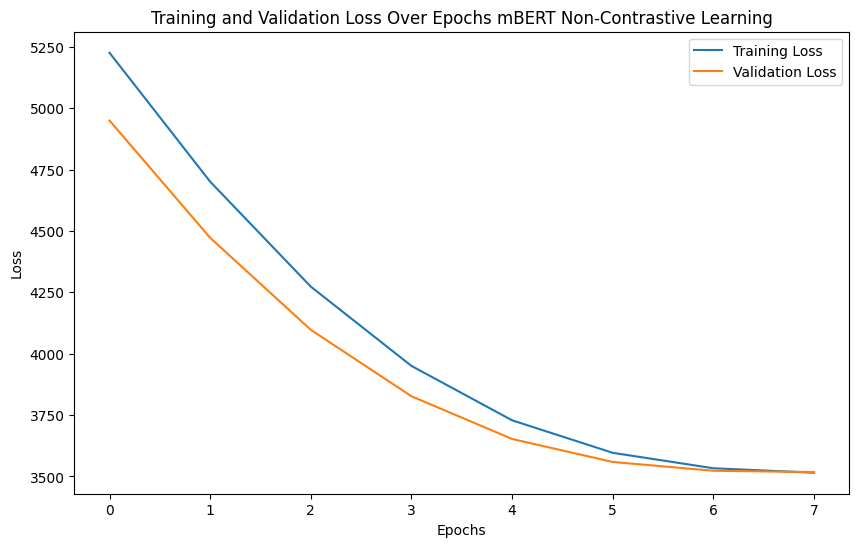

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/8 completed. Training Loss: 5225.8606, Validation Loss: 4948.2246
Epoch 2/8 completed. Training Loss: 4699.8406, Validation Loss: 4470.8443
Epoch 3/8 completed. Training Loss: 4271.5487, Validation Loss: 4094.6231
Epoch 4/8 completed. Training Loss: 3947.2878, Validation Loss: 3822.7029
Epoch 5/8 completed. Training Loss: 3724.1221, Validation Loss: 3646.9923
Epoch 6/8 completed. Training Loss: 3590.2402, Validation Loss: 3552.1565
Epoch 7/8 completed. Training Loss: 3526.5303, Validation Loss: 3515.9027
Epoch 8/8 completed. Training Loss: 3508.0541, Validation Loss: 3510.5607
Training completed


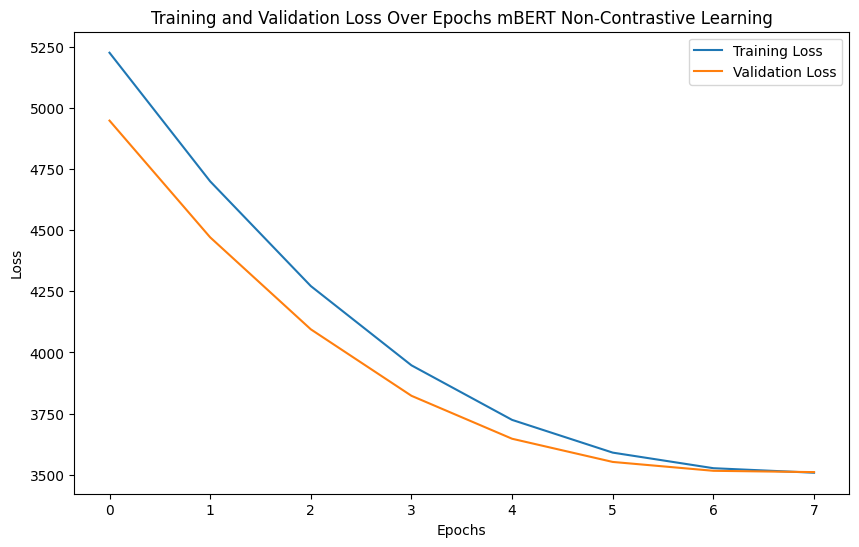

In [ ]:
def save_model(model, filepath):
    torch.save(model.state_dict(), filepath)

def load_model(model, filename, device):
    model.load_state_dict(torch.load(filename, map_location=device))
    return model



model_la_unp_unaug = train_model_non_cont(multilingual_bert_authorship_model_lat_unp_unaug, la_train_unp_unaug, valid_data_unprocessed_la)
save_model(model_la_unp_unaug, 'model_la_unp_unaug.pth')

del multilingual_bert_authorship_model_lat_unp_unaug
torch.cuda.empty_cache()

# Train the English model
model_en_unp_unaug = train_model_non_cont(multilingual_bert_authorship_model_en_unp_unaug, en_train_unp_unaug, valid_data_unprocessed_en)

save_model(model_en_unp_unaug, 'model_en_unp_unaug.pth')

# Clean up
del multilingual_bert_authorship_model_en_unp_unaug
torch.cuda.empty_cache()


Unprocessed Augmented Data:

tensor(0)
Epoch 1/8 completed. Training Loss: 4453.0491, Validation Loss: 3527.3667
Epoch 2/8 completed. Training Loss: 2833.5480, Validation Loss: 2246.6867
Epoch 3/8 completed. Training Loss: 1829.0949, Validation Loss: 1487.1683
Epoch 4/8 completed. Training Loss: 1252.5024, Validation Loss: 1066.6009
Epoch 5/8 completed. Training Loss: 941.4880, Validation Loss: 847.4069
Epoch 6/8 completed. Training Loss: 785.3442, Validation Loss: 744.1443
Epoch 7/8 completed. Training Loss: 718.6076, Validation Loss: 707.4565
Epoch 8/8 completed. Training Loss: 700.1942, Validation Loss: 702.1713
Training completed


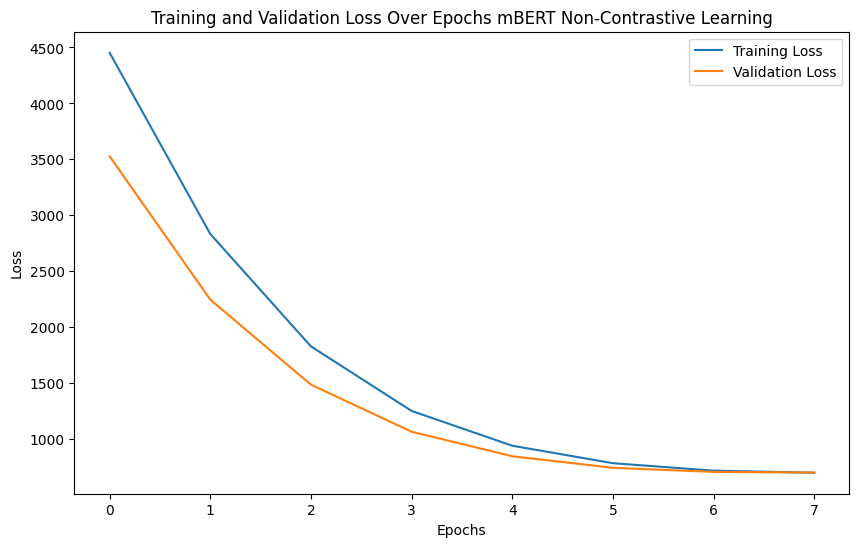

Epoch 1/8 completed. Training Loss: 4465.6157, Validation Loss: 3547.7674
Epoch 2/8 completed. Training Loss: 2856.5325, Validation Loss: 2272.6379
Epoch 3/8 completed. Training Loss: 1855.7618, Validation Loss: 1514.1887
Epoch 4/8 completed. Training Loss: 1278.9445, Validation Loss: 1091.8773
Epoch 5/8 completed. Training Loss: 965.9952, Validation Loss: 870.6264
Epoch 6/8 completed. Training Loss: 808.2197, Validation Loss: 766.3471
Epoch 7/8 completed. Training Loss: 740.5198, Validation Loss: 728.8881
Epoch 8/8 completed. Training Loss: 721.7868, Validation Loss: 723.5009
Training completed


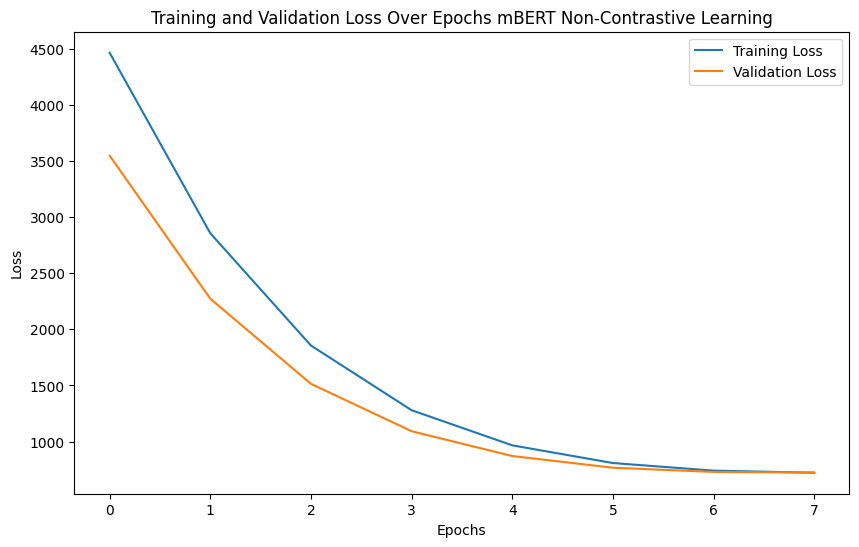

In [ ]:
multilingual_BERT_model__lat_unp_aug = BertModel.from_pretrained("bert-base-multilingual-uncased")
multilingual_BERT_model__en_unp_aug=  BertModel.from_pretrained("bert-base-multilingual-uncased")

classifier_lat_unp_aug = Classifier()
classifier_en_unp_aug = Classifier()


multilingual_bert_authorship_model_unp_aug1 = MultilingualBertForAuthorshipAttribution(multilingual_BERT_model__lat_unp_aug, classifier_lat_unp_aug)
multilingual_bert_authorship_model_unp_aug2= MultilingualBertForAuthorshipAttribution(multilingual_BERT_model__en_unp_aug, classifier_en_unp_aug)
multilingual_BERT_tokenizer= BertTokenizer.from_pretrained('bert-base-multilingual-uncased')

sorted_unp_aug_train= sort_dataframe_by_file(train_data_17k_pre_lem)

la_train_unp_aug, en_train_unp_aug= split_lang(sorted_unp_aug_train, multilingual_BERT_tokenizer)

# Seed for reproducibility
torch.manual_seed(42)

# Shuffle indices for 'la_train_unp_aug'
la_indices = torch.randperm(len(la_train_unp_aug))
la_train_unp_aug = TensorDataset(*[t[la_indices] for t in la_train_unp_aug.tensors])

# Shuffle indices for 'en_train_unp_aug'
en_indices = torch.randperm(len(en_train_unp_aug))
en_train_unp_aug = TensorDataset(*[t[en_indices] for t in en_train_unp_aug.tensors])




model_la_unp_aug = train_model_non_cont(multilingual_bert_authorship_model_unp_aug1, la_train_unp_aug, valid_data_unprocessed_la)
save_model(model_la_unp_aug, 'model_la_unp_aug.pth')

del multilingual_BERT_model__lat_unp_aug
torch.cuda.empty_cache()



model_en_unp_aug = train_model_non_cont(multilingual_bert_authorship_model_unp_aug2, en_train_unp_aug, valid_data_unprocessed_en)

save_model(model_en_unp_aug, 'model_en_unp_aug.pth')

del multilingual_BERT_model__en_unp_aug
torch.cuda.empty_cache()


Lem+SW Augmented Data:

tensor(0)
tensor(0)
tensor(1)
Epoch 1/8 completed. Training Loss: 4460.5091, Validation Loss: 3539.1600
Epoch 2/8 completed. Training Loss: 2845.4046, Validation Loss: 2258.6196
Epoch 3/8 completed. Training Loss: 1840.8133, Validation Loss: 1498.6004
Epoch 4/8 completed. Training Loss: 1263.4435, Validation Loss: 1077.0188
Epoch 5/8 completed. Training Loss: 951.3337, Validation Loss: 856.8618
Epoch 6/8 completed. Training Loss: 794.4568, Validation Loss: 753.0347
Epoch 7/8 completed. Training Loss: 727.3221, Validation Loss: 716.1278
Epoch 8/8 completed. Training Loss: 708.7760, Validation Loss: 710.7991
Training completed


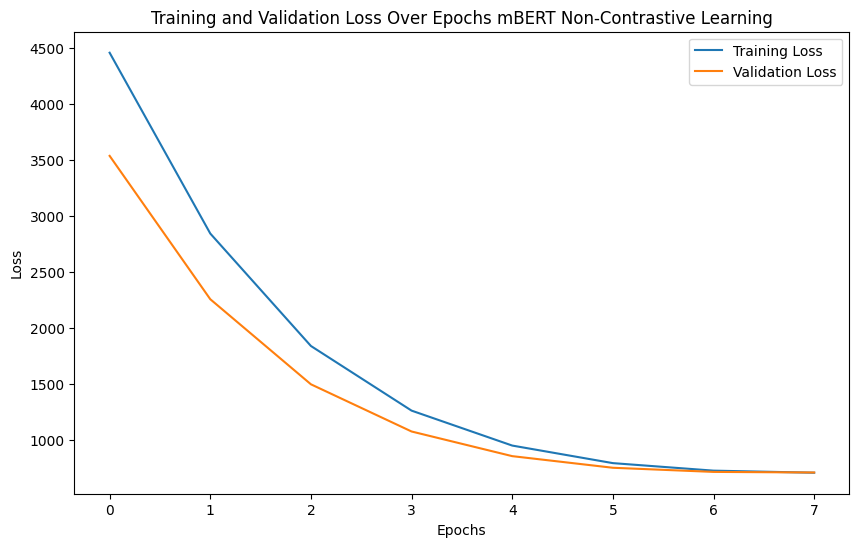

Epoch 1/8 completed. Training Loss: 4460.1703, Validation Loss: 3542.1589
Epoch 2/8 completed. Training Loss: 2852.2456, Validation Loss: 2267.8397
Epoch 3/8 completed. Training Loss: 1851.1215, Validation Loss: 1509.6270
Epoch 4/8 completed. Training Loss: 1274.4243, Validation Loss: 1087.5930
Epoch 5/8 completed. Training Loss: 961.6709, Validation Loss: 866.5698
Epoch 6/8 completed. Training Loss: 804.3423, Validation Loss: 762.5851
Epoch 7/8 completed. Training Loss: 736.8670, Validation Loss: 725.3172
Epoch 8/8 completed. Training Loss: 718.2030, Validation Loss: 719.9442
Training completed


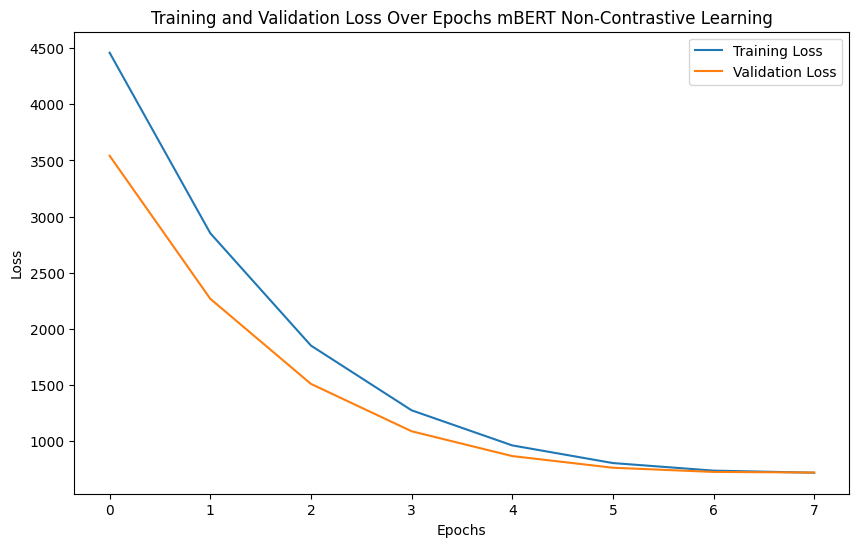

In [ ]:
multilingual_BERT_model__lat_lem_sw_aug = BertModel.from_pretrained("bert-base-multilingual-uncased")
multilingual_BERT_model__en_lem_sw_aug=  BertModel.from_pretrained("bert-base-multilingual-uncased")


classifier_lat_lem_sw_aug = Classifier()
classifier_en_lem_sw_aug = Classifier()

multilingual_bert_authorship_model_lem_sw_augla = MultilingualBertForAuthorshipAttribution(multilingual_BERT_model__lat_lem_sw_aug, classifier_lat_lem_sw_aug)
multilingual_bert_authorship_model_lem_sw_augen= MultilingualBertForAuthorshipAttribution(multilingual_BERT_model__en_lem_sw_aug, classifier_en_lem_sw_aug)

sorted_pre_aug_lem_sw_train= sort_dataframe_by_file(train_data_17k_pre_lem_sw)

sorted_pre_aug_lem_sw_test= sort_dataframe_by_file(test_data_pre_lem_sw)

sorted_pre_aug_lem_sw_test_la, sorted_pre_aug_lem_sw_test_en = split_lang(sorted_pre_aug_lem_sw_test,multilingual_BERT_tokenizer )


la_train_pre_lem_sw_aug, en_train_pre_lem_sw_aug= split_lang(sorted_pre_aug_lem_sw_train, multilingual_BERT_tokenizer)

# Seed for reproducibility
torch.manual_seed(42)

la_indices = torch.randperm(len(la_train_pre_lem_sw_aug))
la_train_pre_lem_sw_aug = TensorDataset(*[t[la_indices] for t in la_train_pre_lem_sw_aug.tensors])

en_indices = torch.randperm(len(en_train_unp_aug))
en_train_pre_lem_sw_aug = TensorDataset(*[t[en_indices] for t in en_train_pre_lem_sw_aug.tensors])




valid_data_lem_sw_la, valid_data_lem_sw_en = split_lang(valid_data_pre_lem_sw, multilingual_BERT_tokenizer)

model_la_pre_lem_sw_aug = train_model_non_cont(multilingual_bert_authorship_model_lem_sw_augla, la_train_pre_lem_sw_aug, valid_data_lem_sw_la)

save_model(model_la_pre_lem_sw_aug, 'model_la_pre_lem_sw_aug.pth')

del multilingual_BERT_model__lat_lem_sw_aug
torch.cuda.empty_cache()



model_en_pre_lem_sw_aug = train_model_non_cont(multilingual_bert_authorship_model_lem_sw_augen, en_train_pre_lem_sw_aug,valid_data_lem_sw_en )

save_model(model_en_pre_lem_sw_aug, 'model_en_pre_lem_sw_aug.pth')

del multilingual_BERT_model__en_lem_sw_aug
torch.cuda.empty_cache()



*Evaluating Accuracy*

In [ ]:
acc_la_unp_unaug = evaluate_model(model_la_unp_unaug, la_test_unp, "la_unprocessed_unaugmented")
acc_en_unp_unaug = evaluate_model(model_en_unp_unaug, en_test_unp, "en_unprocessed_unaugmented")


In [ ]:
acc_la_unp_aug = evaluate_model(model_la_unp_aug, la_test_unp, "la_unprocessed_augmented")
acc_en_unp_aug = evaluate_model(model_en_unp_aug, en_test_unp, "en_unprocessed_augmented")

In [ ]:
acc_la_pre_lem_sw_aug = evaluate_model(model_la_pre_lem_sw_aug, sorted_pre_aug_lem_sw_test_la, "la_lemm_sw_augmented")
acc_en_pre_lem_sw_aug = evaluate_model(model_en_pre_lem_sw_aug, sorted_pre_aug_lem_sw_test_en, "en_lemm_sw_augmented")

In [ ]:
print(f"acc_la_unp_unaug: {acc_la_unp_unaug}" )
print(f"acc_en_unp_unaug: {acc_en_unp_unaug}" )

print(f"acc_la_unp_aug: {acc_la_unp_aug}" )
print(f"acc_en_unp_aug: {acc_en_unp_aug} " )

print(f"acc_la_pre_lem_sw_aug: {acc_la_pre_lem_sw_aug} ")
print(f"acc_en_pre_lem_sw_aug: {acc_en_pre_lem_sw_aug}")

acc_la_unp_unaug: 0.9666666666666667
acc_en_unp_unaug: 0.8944444444444445
acc_la_unp_aug: 0.9694444444444444
acc_en_unp_aug: 0.8916666666666667 
acc_la_pre_lem_sw_aug: 0.9475138121546961 
acc_en_pre_lem_sw_aug: 0.8950276243093923


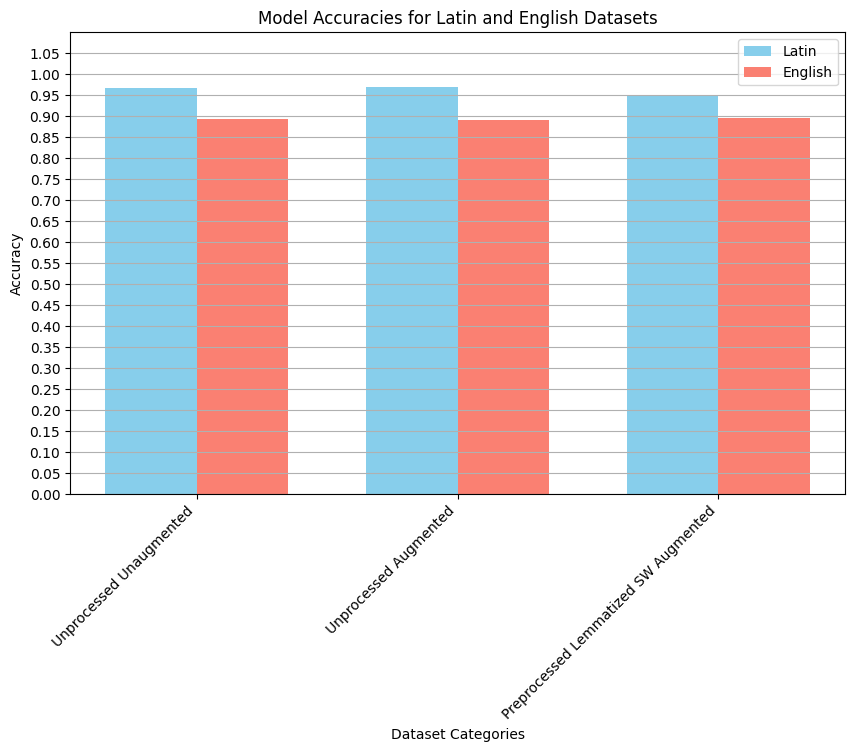

In [ ]:
import numpy as np
latin_labels = ['Unprocessed Unaugmented', 'Unprocessed Augmented', 'Preprocessed Lemmatized SW Augmented']
english_labels = ['Unprocessed Unaugmented', 'Unprocessed Augmented', 'Preprocessed Lemmatized SW Augmented']

latin_values = [acc_la_unp_unaug, acc_la_unp_aug, acc_la_pre_lem_sw_aug]
english_values = [acc_en_unp_unaug, acc_en_unp_aug, acc_en_pre_lem_sw_aug]

plt.figure(figsize=(10, 6))

bar_width = 0.35  # Width of the bars
index = range(len(latin_labels))

latin_bars = plt.bar(index, latin_values, bar_width, label='Latin', color='skyblue')
english_bars = plt.bar([i + bar_width for i in index], english_values, bar_width, label='English', color='salmon')

plt.xlabel('Dataset Categories')
plt.ylabel('Accuracy')
plt.title('Model Accuracies for Latin and English Datasets')
plt.xticks([i + bar_width / 2 for i in index], latin_labels, rotation=45, ha="right")
plt.legend()
plt.yticks(np.arange(0, 1.1, 0.05))
plt.grid(axis='y')
plt.ylim(0, 1.1)
plt.show()
